In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import TargetEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from ydata_profiling import ProfileReport

import optuna
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

## Dataset Description  
**country - The country that the wine is from  
designation - The vineyard within the winery where the grapes that made the wine are from  
points - The number of points WineEnthusiast rated the wine on a scale of 1-100  
price - The cost for a bottle of the wine  
province - The province or state that the wine is from  
region_1 - The wine growing area in a province or state (ie Napa)  
region_2 - Sometimes there are more specific regions specified within a wine growing area  
title - The title of the wine review, which often contains the vintage if you're interested in extracting that feature  
variety - The type of grapes used to make the wine (ie Pinot Noir)  
winery - The winery that made the wine**

In [2]:
%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [3]:
df = pd.read_csv('#\\winemag-data-130k-v2.csv')

In [4]:
df.shape

(129971, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             129971 non-null  int64  
 1   country                129908 non-null  object 
 2   description            129971 non-null  object 
 3   designation            92506 non-null   object 
 4   points                 129971 non-null  int64  
 5   price                  120975 non-null  float64
 6   province               129908 non-null  object 
 7   region_1               108724 non-null  object 
 8   region_2               50511 non-null   object 
 9   taster_name            103727 non-null  object 
 10  taster_twitter_handle  98758 non-null   object 
 11  title                  129971 non-null  object 
 12  variety                129970 non-null  object 
 13  winery                 129971 non-null  object 
dtypes: float64(1), int64(2), object(11)


In [6]:
df.head()

Unnamed: 0   country                                        description  \
0           0     Italy  Aromas include tropical fruit, broom, brimston...   
1           1  Portugal  This is ripe and fruity, a wine that is smooth...   
2           2        US  Tart and snappy, the flavors of lime flesh and...   
3           3        US  Pineapple rind, lemon pith and orange blossom ...   
4           4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’Keefe   
1                  NaN                NaN          Roger Voss   
2    Willamette Valley  Willamette Valley        Paul Gregutt   
3  Lake Michigan Shore                NaN  Alexander Peartree   
4    Willamette Valley  Willamette Valley        Paul Gregutt   

  taster_twitter_handle                                              title  \
0          @kerinokeefe                  Nicosia 2013 Vulkà Bianco  (Etna)   
1            @vossroger      Quinta dos Avidagos 2011 Avidagos Red (Douro)   
2           @paulgwine       Rainstorm 2013 Pinot Gris (Willamette Valley)   
3                   NaN  St. Julian 2013 Reserve Late Harvest Riesling ...   
4           @paulgwine   Sweet Cheeks 2012 Vintner's Reserve Wild Child...   

          variety               winery  
0     White Blend              Nicosia  
1  Portuguese Red  Quinta dos Avidagos  
2      Pinot Gris            Rainstorm  
3        Riesling           St. Julian  
4      Pinot Noir         Sweet Cheeks

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

Unnamed: 0                   0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [9]:
(df.isna().sum() / len(df)) * 100

Unnamed: 0                0.000000
country                   0.048472
description               0.000000
designation              28.825661
points                    0.000000
price                     6.921544
province                  0.048472
region_1                 16.347493
region_2                 61.136715
taster_name              20.192197
taster_twitter_handle    24.015357
title                     0.000000
variety                   0.000769
winery                    0.000000
dtype: float64

In [10]:
profile = ProfileReport(df, title="Wine Report", explorative=True)

In [11]:
profile.to_file("wine_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
df.describe()

Unnamed: 0         points          price
count  129971.000000  129971.000000  120975.000000
mean    64985.000000      88.447138      35.363389
std     37519.540256       3.039730      41.022218
min         0.000000      80.000000       4.000000
25%     32492.500000      86.000000      17.000000
50%     64985.000000      88.000000      25.000000
75%     97477.500000      91.000000      42.000000
max    129970.000000     100.000000    3300.000000

**It can be seen that the ratings have outliers at both the upper and lower end. This is inevitable, as some wines can taste very bad and some very good.  
The price also has outliers, which seems normal.**

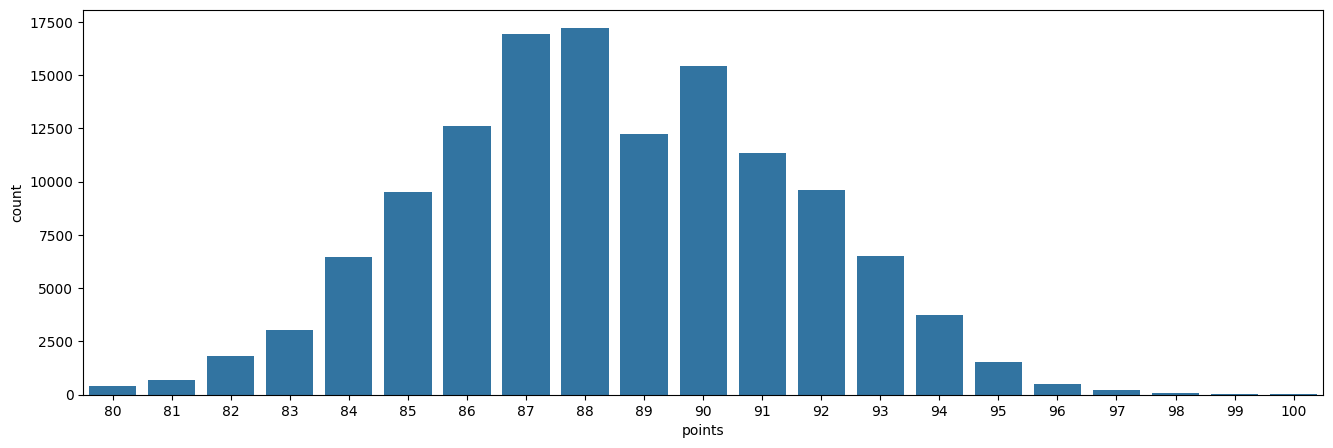

In [14]:
plt.figure(figsize=(16,5))
g = sns.countplot(x='points', data=df)

**The scores are mostly concentrated between 86-90 points. But there are wines that received scores below 82 and 100 points.  
The distribution tends to be normal**

<Axes: xlabel='country'>

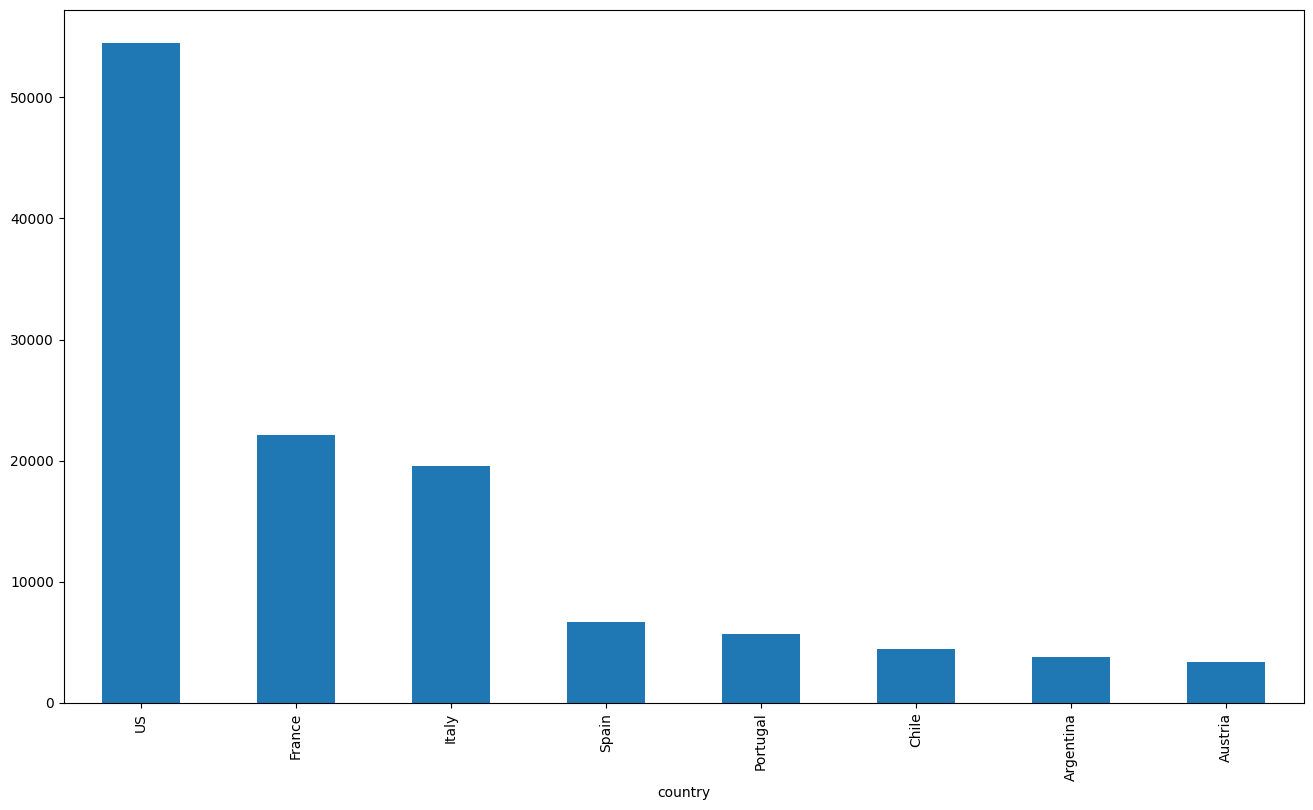

In [15]:
plt.figure(figsize=(16,9))
df['country'].value_counts().head(8).plot.bar()

**Most ratings from Britain and France**

<Axes: title={'center': 'Prices of wine'}, xlabel='price'>

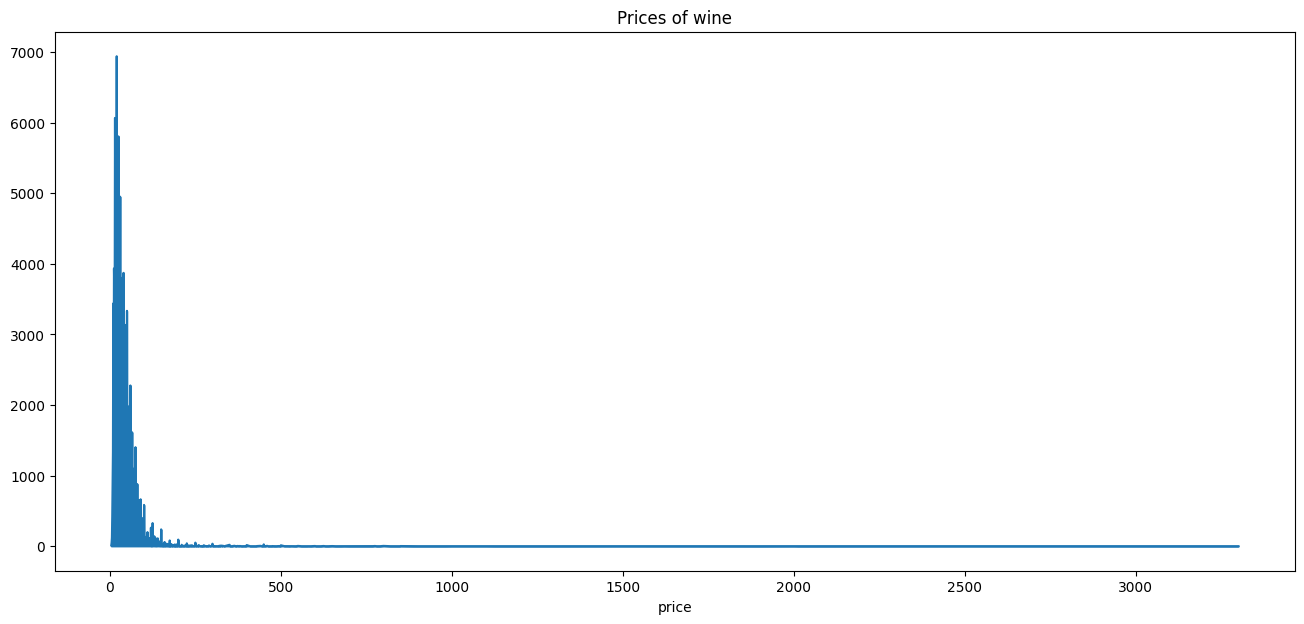

In [16]:
df['price'].value_counts().sort_index().plot.area(
    figsize = (16,7),
    title = 'Prices of wine'
)

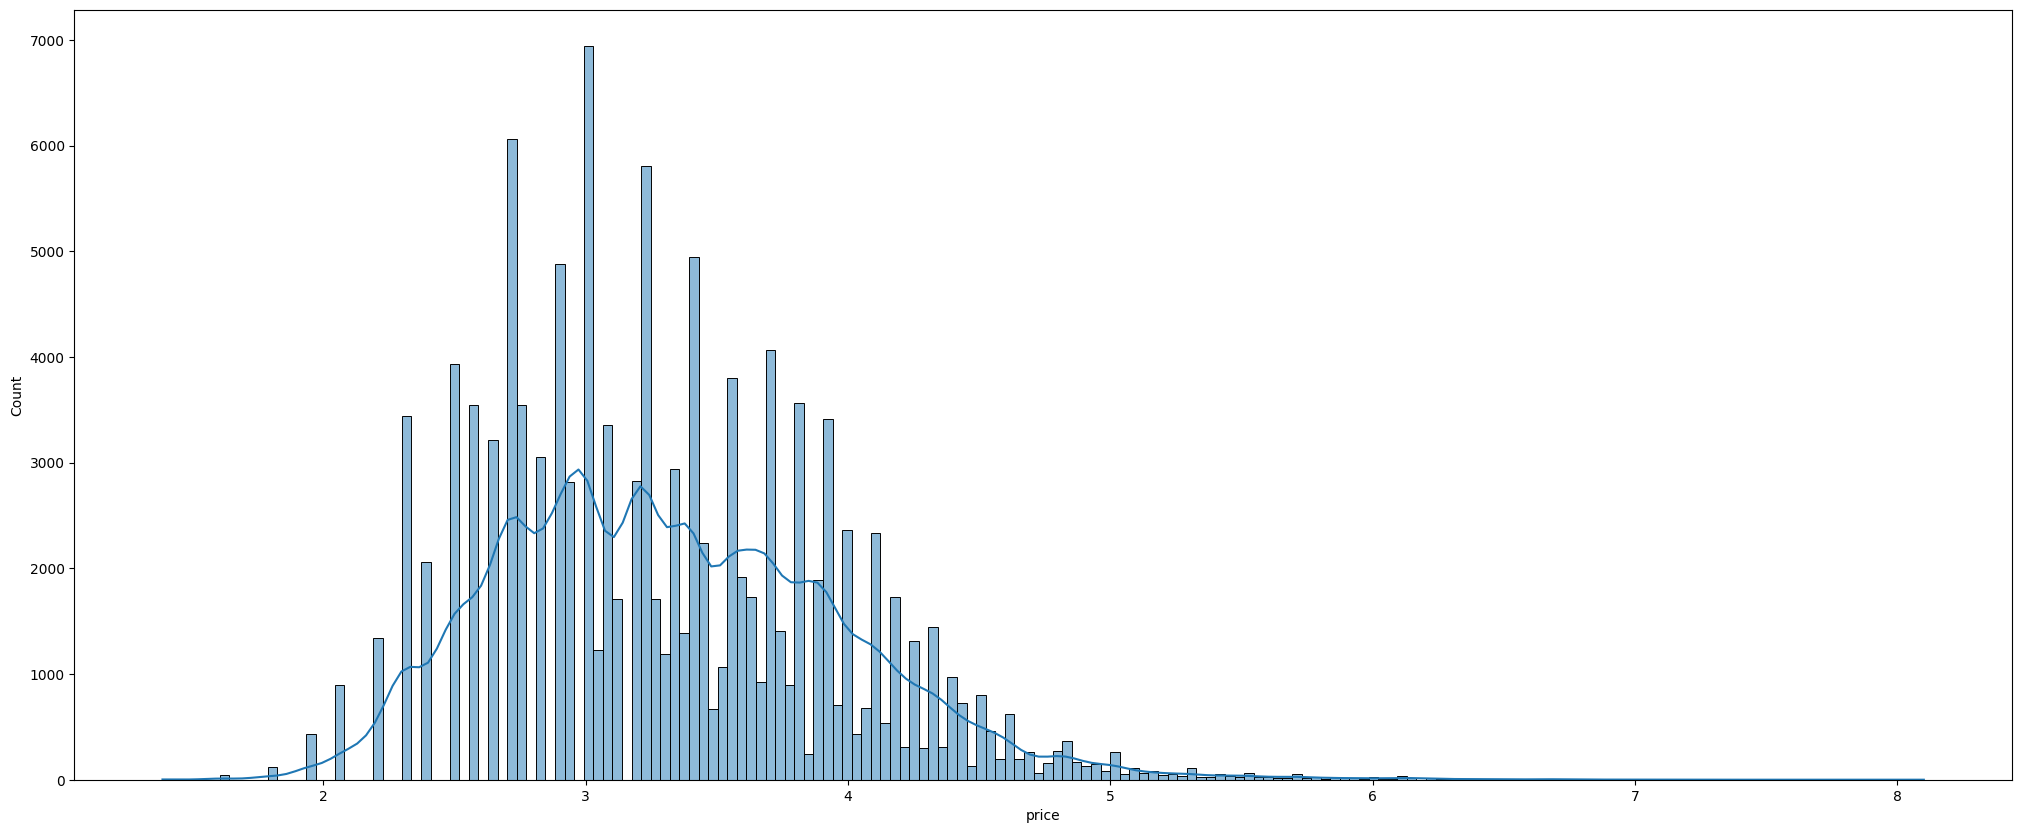

In [17]:
plt.figure(figsize=(25,10))
g = sns.histplot(data = np.log(df['price']), kde = True)

**The prices for most wines are generally in the 25-40 range.  
However, there are wines that are very expensive.**

<Axes: xlabel='points', ylabel='log_price'>

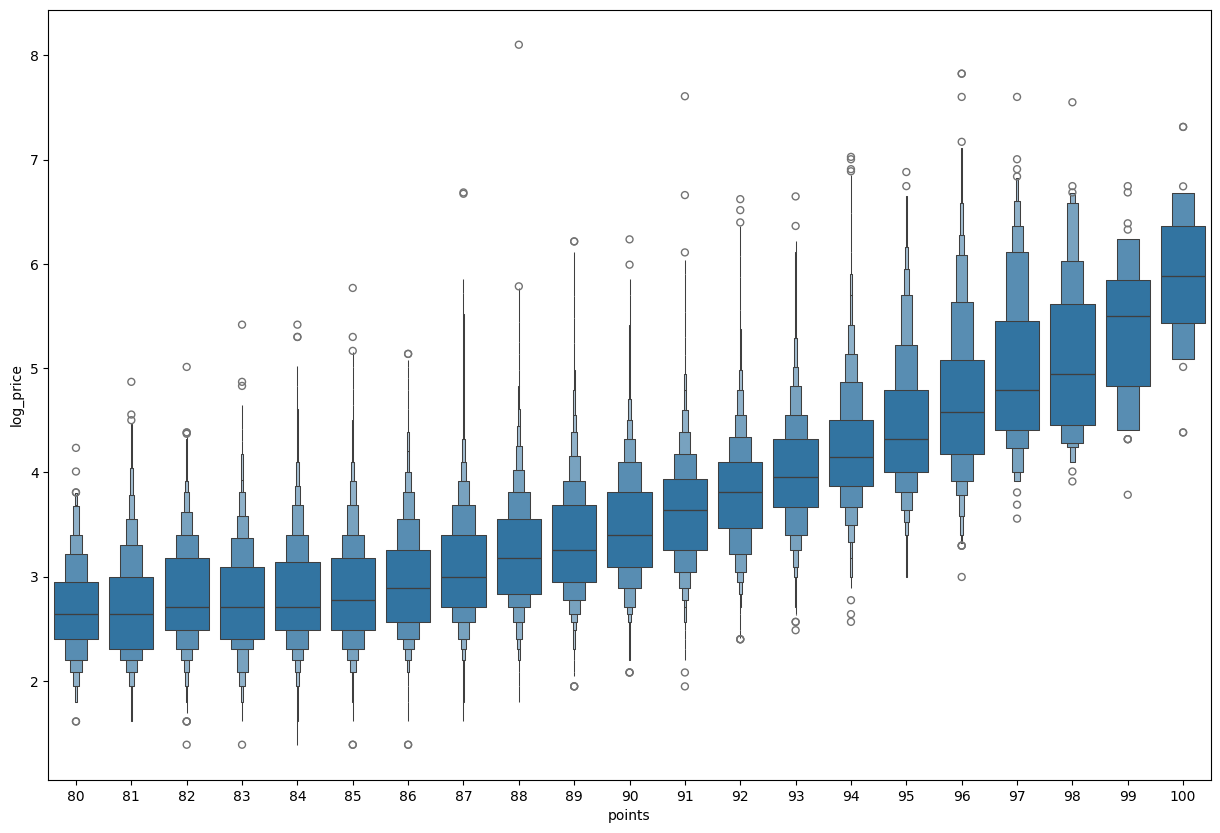

In [18]:
df1 = df.copy()
df1['log_price'] = np.log(df1['price'])
plt.figure(figsize=(15, 10))
sns.boxenplot(data = df1, x="points", y="log_price", k_depth="trustworthy")

**It can be seen that there is a significant positive correlation between price and the score a wine receives  
Wines with a price range of 0 to 500 receive poor scores. Scores for cheaper wines are split between 80 and 100. This suggests that cheaper wines can be equally liked by all critics.**

In [19]:
import missingno as msno

<Axes: >

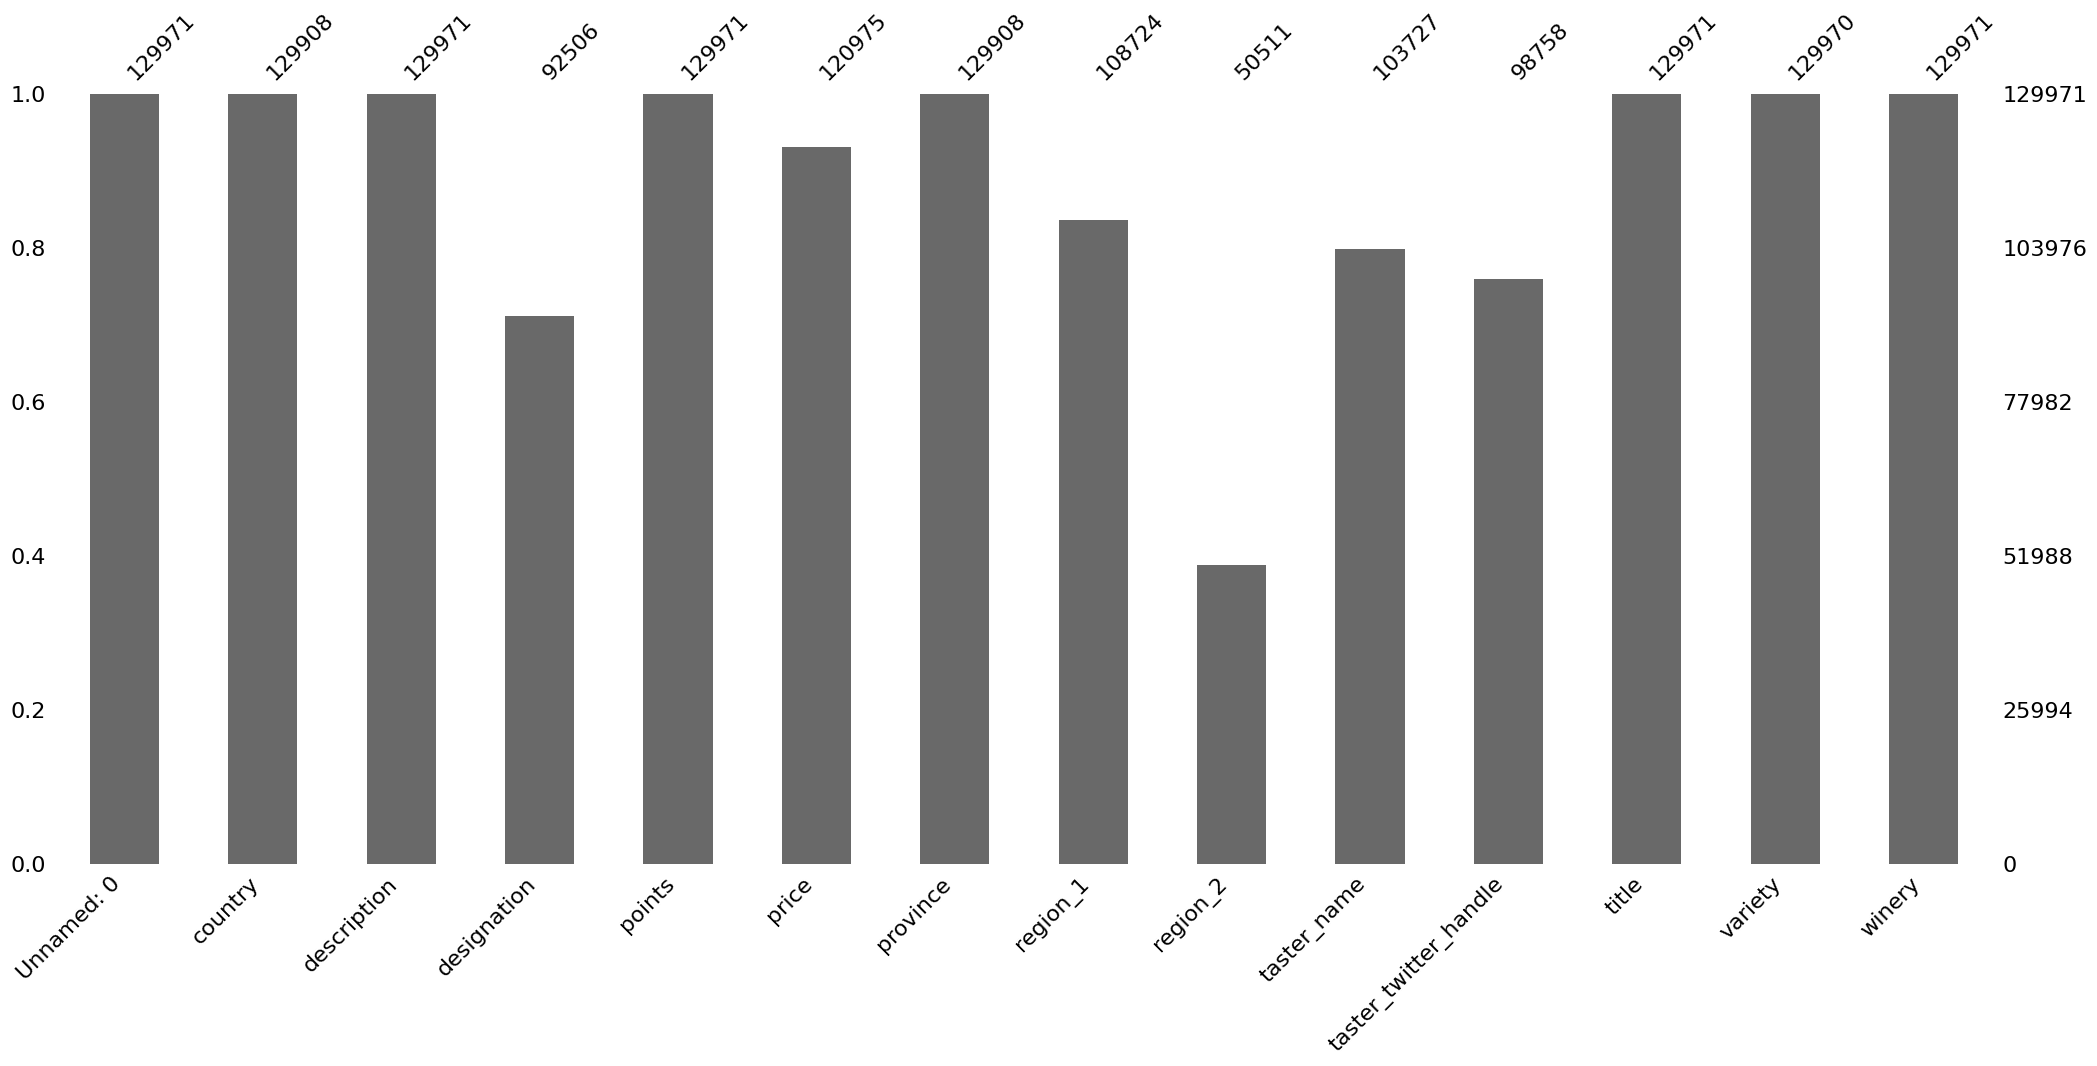

In [20]:
msno.bar(df)

<Axes: >

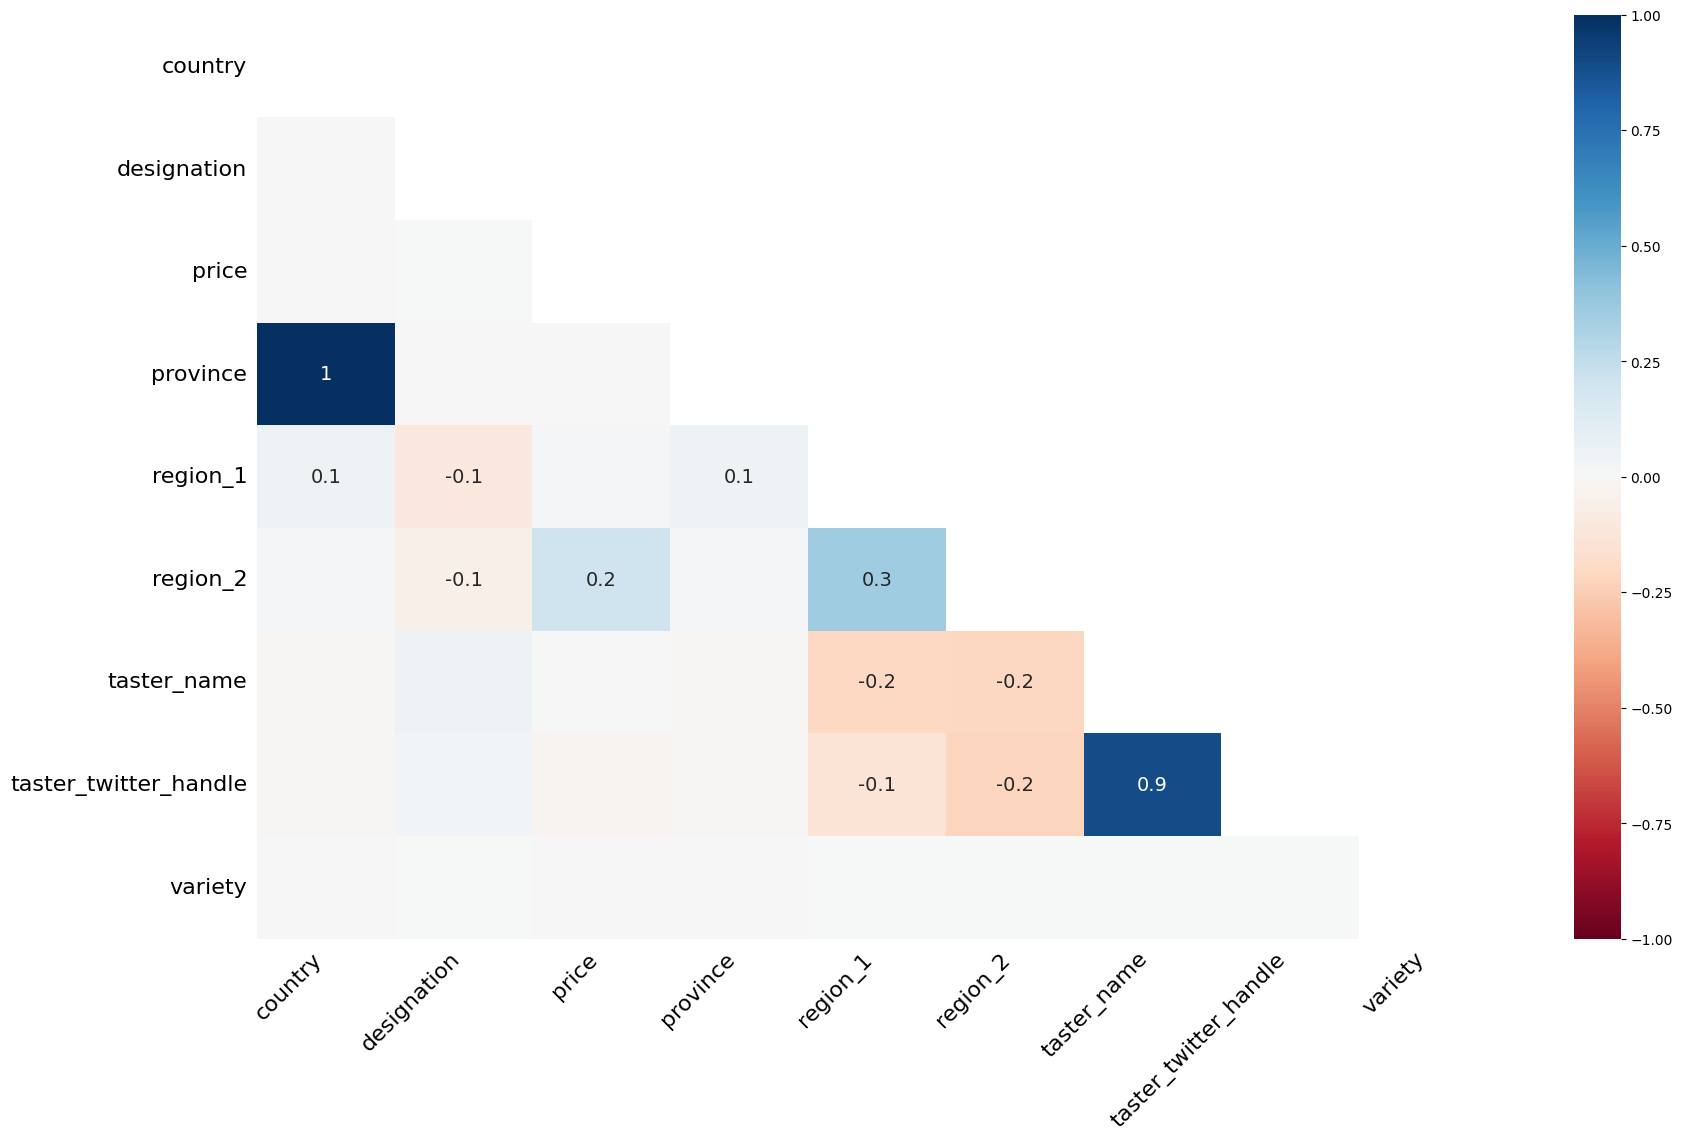

In [21]:
msno.heatmap(df)

In [22]:
#Working with nuls
df.fillna({'country' : 'US'}, inplace = True)

#Fills in the most frequent value by country/province
most_province = df.groupby('country')['province'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['province'] = df.apply(lambda row: most_province[row['country']] if pd.isna(row['province']) else row['province'], axis=1)

most_region = df.groupby('country')['region_1'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['region_1'] = df.apply(lambda row: most_region[row['country']] if pd.isna(row['region_1']) else row['region_1'], axis=1)

most_price = df.groupby('province')['price'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['price'] = df.apply(lambda row: most_price[row['province']] if pd.isna(row['price']) else row['price'], axis=1)

most_designation = df.groupby('province')['designation'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
df['designation'] = df.apply(lambda row: most_designation[row['province']] if pd.isna(row['designation']) else row['designation'], axis=1)

In [23]:
#We fill it up with mode
df['variety'] = df['variety'].fillna(df['variety'].mode().squeeze())
df['region_1'] = df['region_1'].fillna(df['region_1'].mode().squeeze())
df['designation'] = df['designation'].fillna(df['designation'].mode().squeeze())

In [24]:
df['log_price'] = np.log(df['price'])
df['log_price'] = df['log_price'].fillna(df['log_price'].mean().squeeze())
del df['price']

In [25]:
del df['description']
del df['taster_name']
del df['taster_twitter_handle']
del df['Unnamed: 0']
del df['region_2']
del df['title']

In [26]:
(df.isna().sum() / len(df)) * 100

country        0.0
designation    0.0
points         0.0
province       0.0
region_1       0.0
variety        0.0
winery         0.0
log_price      0.0
dtype: float64

**Working with emissions**

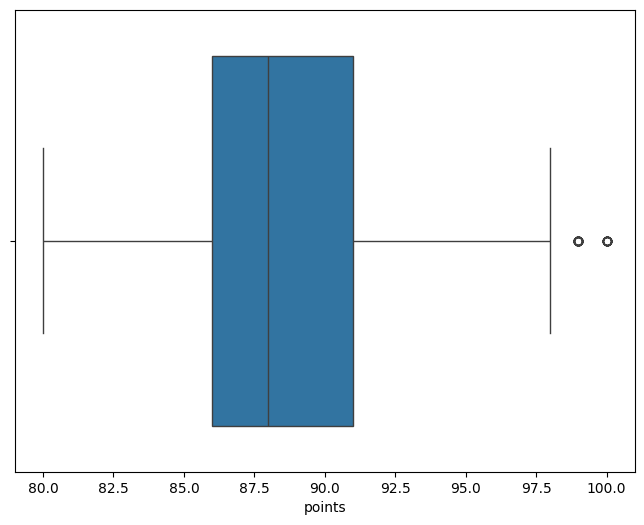

In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='points')
plt.show()

In [28]:
Q1 = df['points'].quantile(0.25) 
Q3 = df['points'].quantile(0.75)  
IQR = Q3 - Q1 

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['points'] >= lower_bound) & (df['points'] <= upper_bound)]

df.describe()

points      log_price
count  129919.000000  129919.000000
mean       88.442768       3.290106
std         3.032463       0.645008
min        80.000000       1.386294
25%        86.000000       2.772589
50%        88.000000       3.218876
75%        91.000000       3.688879
max        98.000000       8.101678

**Coding of categorical**

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129919 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      129919 non-null  object 
 1   designation  129919 non-null  object 
 2   points       129919 non-null  int64  
 3   province     129919 non-null  object 
 4   region_1     129919 non-null  object 
 5   variety      129919 non-null  object 
 6   winery       129919 non-null  object 
 7   log_price    129919 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 8.9+ MB


In [30]:
encoder = TargetEncoder()

df.loc[:, 'country_encoded'] = encoder.fit_transform(df['country'], df['points'])
df.loc[:, 'province_encoded'] = encoder.fit_transform(df['province'], df['points'])
df.loc[:, 'region_1_encoded'] = encoder.fit_transform(df['region_1'], df['points'])
df.loc[:, 'designation_encoded'] = encoder.fit_transform(df['designation'], df['points'])
df.loc[:, 'winery_encoded'] = encoder.fit_transform(df['winery'], df['points'])
df.loc[:, 'variety_encoded'] = encoder.fit_transform(df['variety'], df['points'])

df = df.drop(columns=['country', 'province', 'region_1', 'designation', 'winery', 'variety'])

C:\Users\Gamabumba\AppData\Local\Temp\ipykernel_6556\2624515176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'country_encoded'] = encoder.fit_transform(df['country'], df['points'])
C:\Users\Gamabumba\AppData\Local\Temp\ipykernel_6556\2624515176.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'province_encoded'] = encoder.fit_transform(df['province'], df['points'])
C:\Users\Gamabumba\AppData\Local\Temp\ipykernel_6556\2624515176.py:5: SettingWithCopyWarning: 
A value is trying t

**Why not a one-hot encoder?  
A large number of categories  
Problem of semantic interpretation (the relationship between variables will not be taken into account)  
For regression with a continuous target variable, methods that take into account the relationship of categories with the target feature are more convenient**

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129919 entries, 0 to 129970
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   points               129919 non-null  int64  
 1   log_price            129919 non-null  float64
 2   country_encoded      129919 non-null  float64
 3   province_encoded     129919 non-null  float64
 4   region_1_encoded     129919 non-null  float64
 5   designation_encoded  129919 non-null  float64
 6   winery_encoded       129919 non-null  float64
 7   variety_encoded      129919 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 8.9 MB


In [32]:
SEED = 42

train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)

In [33]:
X = train_df[['log_price', 'country_encoded', 'region_1_encoded', 'province_encoded', 'designation_encoded', 'winery_encoded', 'variety_encoded']]
y = train_df.points
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=SEED)

In [36]:
def objective_xgboost(trial):
    params = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),  
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.1, 10, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 0.9), 
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.9),  
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
    }

    # Training a model with early stopping
    model = XGBRegressor(**params, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    # Predictions and quality assessment
    pred_test = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)  # Вычисляем RMSE

    return rmse_test  # Target Metric for Minimization

cd_study = optuna.create_study(direction='minimize')
cd_study.optimize(objective_xgboost, n_trials=50, timeout=600)

[I 2024-11-11 19:45:59,122] A new study created in memory with name: no-name-c7e3e495-d979-421a-b59d-f3c7542de47d
D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 19:46:25,094] Trial 0 finished with value: 1.839253850703032 and parameters: {'booster': 'dart', 'learning_rate': 0.013406458004637096, 'n_estimators': 159, 'max_depth': 7, 'min_child_weight': 1.733646520226539, 'gamma': 0.46375944422273574, 'subsample': 0.7594337055356191, 'colsample_bytree': 0.6741994996044107, 'lambda': 0.3123255699764991, 'alpha': 9.265895510781655e-06}. Best is trial 0 with value: 1.839253850703032.
D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the fun

In [35]:
def objective_lightgbm(trial):
    params = {
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),  
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 10, log=True), 
        "subsample": 1.0 if trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]) == "goss" else trial.suggest_float("subsample", 0.5, 1.0),  # Conditional for GOSS
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10) if trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]) != "goss" else 0,
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),  
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True), 
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True)  
    }

    
    
    model = LGBMRegressor(**params, random_state=42)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)]
    )
    
    pred_test = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)  # Вычисляем RMSE

    return rmse_test  

cd_study = optuna.create_study(direction='minimize')
cd_study.optimize(objective_lightgbm, n_trials=50)

[I 2024-11-11 20:00:36,362] A new study created in memory with name: no-name-e76d527a-bef7-4627-ba35-120f20626762


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:37,121] Trial 0 finished with value: 1.740721411320668 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 277, 'learning_rate': 0.0642961459553387, 'n_estimators': 423, 'max_depth': 4, 'min_child_samples': 21, 'min_child_weight': 0.0047923552459993276, 'subsample': 0.7221163835850328, 'subsample_freq': 8, 'colsample_bytree': 0.6103531563391733, 'reg_alpha': 1.722200135647556e-06, 'reg_lambda': 9.80658376345936e-06}. Best is trial 0 with value: 1.740721411320668.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start training from score 

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:38,034] Trial 1 finished with value: 1.6865939509820949 and parameters: {'boosting_type': 'goss', 'num_leaves': 291, 'learning_rate': 0.06097442035738212, 'n_estimators': 241, 'max_depth': 10, 'min_child_samples': 41, 'min_child_weight': 1.1876686760002493, 'colsample_bytree': 0.7359064105960015, 'reg_alpha': 0.016654227964869806, 'reg_lambda': 0.0002508675518718147}. Best is trial 1 with value: 1.6865939509820949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:43,040] Trial 2 finished with value: 2.02023618662088 and parameters: {'boosting_type': 'dart', 'num_leaves': 23, 'learning_rate': 0.259623447581888, 'n_estimators': 441, 'max_depth': 12, 'min_child_samples': 5, 'min_child_weight': 0.003128305030874054, 'subsample': 0.6351383774350938, 'subsample_freq': 9, 'colsample_bytree': 0.7448853278047443, 'reg_alpha': 0.7681580788465722, 'reg_lambda': 0.0016870669519093884}. Best is trial 1 with value: 1.6865939509820949.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:43,727] Trial 3 finished with value: 1.707408788797879 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 206, 'learning_rate': 0.06385807838051365, 'n_estimators': 313, 'max_depth': 6, 'min_child_samples': 68, 'min_child_weight': 1.0898167684276465, 'subsample': 0.6179164380295871, 'subsample_freq': 8, 'colsample_bytree': 0.579847237407561, 'reg_alpha': 1.7741743866788309, 'reg_lambda': 0.386090693899015}. Best is trial 1 with value: 1.6865939509820949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:46,293] Trial 4 finished with value: 2.356694602014097 and parameters: {'boosting_type': 'dart', 'num_leaves': 257, 'learning_rate': 0.19779390029408475, 'n_estimators': 245, 'max_depth': 14, 'min_child_samples': 37, 'min_child_weight': 0.6185117092785339, 'subsample': 0.6386614939019744, 'subsample_freq': 10, 'colsample_bytree': 0.9551637134235009, 'reg_alpha': 0.006324627423677022, 'reg_lambda': 2.1369670436426076}. Best is trial 1 with value: 1.6865939509820949.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_str

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:48,282] Trial 5 finished with value: 1.6913031376106589 and parameters: {'boosting_type': 'goss', 'num_leaves': 178, 'learning_rate': 0.09536594482814492, 'n_estimators': 451, 'max_depth': 16, 'min_child_samples': 63, 'min_child_weight': 0.0058046983865638795, 'colsample_bytree': 0.6203916860609424, 'reg_alpha': 0.0008059086758919872, 'reg_lambda': 0.0005723445854209598}. Best is trial 1 with value: 1.6865939509820949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:48,612] Trial 6 finished with value: 1.903986856149294 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 99, 'learning_rate': 0.013685539618779254, 'n_estimators': 106, 'max_depth': 9, 'min_child_samples': 50, 'min_child_weight': 3.5144497391142324, 'subsample': 0.8439753701351981, 'subsample_freq': 10, 'colsample_bytree': 0.7361703445895547, 'reg_alpha': 2.2833657615410328e-07, 'reg_lambda': 0.04085987177262032}. Best is trial 1 with value: 1.6865939509820949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:50,150] Trial 7 finished with value: 1.6825457633478527 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 295, 'learning_rate': 0.04640883394234399, 'n_estimators': 422, 'max_depth': 11, 'min_child_samples': 90, 'min_child_weight': 0.0011101555708445533, 'subsample': 0.7156705642557978, 'subsample_freq': 9, 'colsample_bytree': 0.9950151686164582, 'reg_alpha': 0.0025181171539074673, 'reg_lambda': 0.010951719566661616}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_str

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:50,550] Trial 8 finished with value: 1.879589407598482 and parameters: {'boosting_type': 'goss', 'num_leaves': 200, 'learning_rate': 0.06589028603275825, 'n_estimators': 275, 'max_depth': 2, 'min_child_samples': 91, 'min_child_weight': 0.2812178509279982, 'colsample_bytree': 0.6375166060375851, 'reg_alpha': 1.5575558354477967e-07, 'reg_lambda': 3.934478667346974e-07}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:56,746] Trial 9 finished with value: 2.5906101426610557 and parameters: {'boosting_type': 'dart', 'num_leaves': 223, 'learning_rate': 0.10394915629530406, 'n_estimators': 309, 'max_depth': 17, 'min_child_samples': 19, 'min_child_weight': 0.01218551700048215, 'subsample': 0.9550743097225793, 'subsample_freq': 7, 'colsample_bytree': 0.6143903538129711, 'reg_alpha': 0.00012763563830981553, 'reg_lambda': 7.892938395716873e-07}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:58,533] Trial 10 finished with value: 1.6946596203181907 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'learning_rate': 0.020729711738103996, 'n_estimators': 492, 'max_depth': 20, 'min_child_samples': 98, 'min_child_weight': 0.051703724740728825, 'subsample': 0.5061823136663045, 'subsample_freq': 3, 'colsample_bytree': 0.9938449178770707, 'reg_alpha': 1.650882454000166e-05, 'reg_lambda': 1.1309730901520555e-08}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start training from score 

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:59,130] Trial 11 finished with value: 1.727434524626419 and parameters: {'boosting_type': 'goss', 'num_leaves': 297, 'learning_rate': 0.030651881281512666, 'n_estimators': 142, 'max_depth': 9, 'min_child_samples': 77, 'min_child_weight': 6.902733405065691, 'colsample_bytree': 0.8679601445548285, 'reg_alpha': 0.024985514262197025, 'reg_lambda': 0.015668754454984512}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start training from score 

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:00:59,915] Trial 12 finished with value: 1.696379186844305 and parameters: {'boosting_type': 'goss', 'num_leaves': 249, 'learning_rate': 0.03302762724554097, 'n_estimators': 175, 'max_depth': 11, 'min_child_samples': 40, 'min_child_weight': 0.0011943630550842546, 'colsample_bytree': 0.8478487436990263, 'reg_alpha': 0.04675257335323962, 'reg_lambda': 3.062620117198515e-05}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:00,802] Trial 13 finished with value: 1.717777677563834 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 292, 'learning_rate': 0.033405745819877625, 'n_estimators': 370, 'max_depth': 6, 'min_child_samples': 82, 'min_child_weight': 0.030931549521634953, 'subsample': 0.8281667314146007, 'subsample_freq': 4, 'colsample_bytree': 0.8338385048651304, 'reg_alpha': 0.0005301745582038785, 'reg_lambda': 0.005585124391917966}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_str

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:01,450] Trial 14 finished with value: 1.6977878702619222 and parameters: {'boosting_type': 'goss', 'num_leaves': 239, 'learning_rate': 0.13736794922841858, 'n_estimators': 210, 'max_depth': 8, 'min_child_samples': 53, 'min_child_weight': 0.17643759271669476, 'colsample_bytree': 0.51651393153843, 'reg_alpha': 0.14017615558530067, 'reg_lambda': 7.55844639802272e-05}. Best is trial 7 with value: 1.6825457633478527.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:02,389] Trial 15 finished with value: 1.6644452994464576 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 122, 'learning_rate': 0.042700546203416755, 'n_estimators': 346, 'max_depth': 13, 'min_child_samples': 36, 'min_child_weight': 1.6874235419894177, 'subsample': 0.9724543194012585, 'subsample_freq': 1, 'colsample_bytree': 0.6932705029254099, 'reg_alpha': 0.0030344511738759398, 'reg_lambda': 0.14643601374520335}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:03,587] Trial 16 finished with value: 1.7131892962256299 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 125, 'learning_rate': 0.010349178422745554, 'n_estimators': 374, 'max_depth': 14, 'min_child_samples': 25, 'min_child_weight': 0.0800929661147675, 'subsample': 0.986728561328948, 'subsample_freq': 1, 'colsample_bytree': 0.6809518899629782, 'reg_alpha': 1.1808489657707395e-08, 'reg_lambda': 8.051399785634272}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001007 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:04,493] Trial 17 finished with value: 1.6815283337579532 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'learning_rate': 0.04123696451390532, 'n_estimators': 383, 'max_depth': 13, 'min_child_samples': 63, 'min_child_weight': 0.016957488924561736, 'subsample': 0.823403684411464, 'subsample_freq': 5, 'colsample_bytree': 0.7917629391491191, 'reg_alpha': 3.429491524826456e-05, 'reg_lambda': 0.19033261012151048}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:04,664] Trial 18 finished with value: 2.0681490667881826 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'learning_rate': 0.019527459987233414, 'n_estimators': 51, 'max_depth': 18, 'min_child_samples': 63, 'min_child_weight': 0.013132776478327002, 'subsample': 0.8818560329852752, 'subsample_freq': 1, 'colsample_bytree': 0.7936157033198841, 'reg_alpha': 0.00012282579083000897, 'reg_lambda': 0.19115691974204932}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000284 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:05,620] Trial 19 finished with value: 1.6952814772436913 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 66, 'learning_rate': 0.02547936681355863, 'n_estimators': 358, 'max_depth': 14, 'min_child_samples': 53, 'min_child_weight': 8.738736948164492, 'subsample': 0.9170622405471006, 'subsample_freq': 5, 'colsample_bytree': 0.6925937410341052, 'reg_alpha': 4.816230963541531e-06, 'reg_lambda': 0.2159853575666611}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:06,762] Trial 20 finished with value: 1.669910171171747 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'learning_rate': 0.041426543211050874, 'n_estimators': 311, 'max_depth': 15, 'min_child_samples': 32, 'min_child_weight': 0.026996449673416405, 'subsample': 0.7940550082384894, 'subsample_freq': 3, 'colsample_bytree': 0.8994720204832046, 'reg_alpha': 9.621389331727997, 'reg_lambda': 1.8799935350598613}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:07,884] Trial 21 finished with value: 1.6663986086184164 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 139, 'learning_rate': 0.04372261804374697, 'n_estimators': 338, 'max_depth': 13, 'min_child_samples': 31, 'min_child_weight': 0.025006163071062792, 'subsample': 0.7890524430803653, 'subsample_freq': 3, 'colsample_bytree': 0.9098559409922001, 'reg_alpha': 2.0920709764638436e-05, 'reg_lambda': 1.8497457779711748}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:09,078] Trial 22 finished with value: 1.6690987201087093 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 151, 'learning_rate': 0.04330064277296159, 'n_estimators': 320, 'max_depth': 16, 'min_child_samples': 32, 'min_child_weight': 0.14331958311868737, 'subsample': 0.7699929735967449, 'subsample_freq': 3, 'colsample_bytree': 0.9130765269351333, 'reg_alpha': 9.327237963985056, 'reg_lambda': 6.795106664550026}. Best is trial 15 with value: 1.6644452994464576.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:10,176] Trial 23 finished with value: 1.6591524054390179 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 160, 'learning_rate': 0.09030598393634366, 'n_estimators': 329, 'max_depth': 19, 'min_child_samples': 12, 'min_child_weight': 0.19796378038294885, 'subsample': 0.7565960063904295, 'subsample_freq': 2, 'colsample_bytree': 0.9273904191691764, 'reg_alpha': 0.492475911166092, 'reg_lambda': 6.304850299939579}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:11,381] Trial 24 finished with value: 1.6723477514829557 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 173, 'learning_rate': 0.0930142503314556, 'n_estimators': 339, 'max_depth': 20, 'min_child_samples': 8, 'min_child_weight': 0.3916273423790417, 'subsample': 0.6883801832297749, 'subsample_freq': 2, 'colsample_bytree': 0.9391733842016273, 'reg_alpha': 0.5522679783983113, 'reg_lambda': 1.0123750864817864}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:15,176] Trial 25 finished with value: 3.4542010931597735 and parameters: {'boosting_type': 'dart', 'num_leaves': 97, 'learning_rate': 0.11942309543247233, 'n_estimators': 274, 'max_depth': 18, 'min_child_samples': 12, 'min_child_weight': 2.444852791512738, 'subsample': 0.8814665869372226, 'subsample_freq': 2, 'colsample_bytree': 0.784997690841658, 'reg_alpha': 0.0029102114854270373, 'reg_lambda': 0.0864202686206905}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:16,101] Trial 26 finished with value: 1.6684044341593183 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 98, 'learning_rate': 0.0786600286287644, 'n_estimators': 396, 'max_depth': 18, 'min_child_samples': 15, 'min_child_weight': 0.06275574443817046, 'subsample': 0.5708870573851585, 'subsample_freq': 1, 'colsample_bytree': 0.8946426395079716, 'reg_alpha': 0.09541018595601214, 'reg_lambda': 6.9513678680518405}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:17,026] Trial 27 finished with value: 1.6720613096323007 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 163, 'learning_rate': 0.14962065941236025, 'n_estimators': 263, 'max_depth': 12, 'min_child_samples': 25, 'min_child_weight': 1.098084725372307, 'subsample': 0.7505559990196395, 'subsample_freq': 2, 'colsample_bytree': 0.6866272375851896, 'reg_alpha': 2.1184506540727335e-06, 'reg_lambda': 0.8051342430054882}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:18,303] Trial 28 finished with value: 1.674064761290215 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 188, 'learning_rate': 0.05355300843742862, 'n_estimators': 477, 'max_depth': 7, 'min_child_samples': 30, 'min_child_weight': 2.726760803640439, 'subsample': 0.9896024285156634, 'subsample_freq': 4, 'colsample_bytree': 0.9436428483163104, 'reg_alpha': 2.395259653485387e-05, 'reg_lambda': 0.04811641607138876}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000868 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:19,038] Trial 29 finished with value: 1.721161990838782 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 119, 'learning_rate': 0.07885108672834858, 'n_estimators': 413, 'max_depth': 4, 'min_child_samples': 47, 'min_child_weight': 0.26543464562121877, 'subsample': 0.9123198517181281, 'subsample_freq': 2, 'colsample_bytree': 0.8319057073818942, 'reg_alpha': 4.794292872587059e-07, 'reg_lambda': 0.002716177975066093}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:21,487] Trial 30 finished with value: 21.27020295488817 and parameters: {'boosting_type': 'dart', 'num_leaves': 152, 'learning_rate': 0.019073948563434195, 'n_estimators': 341, 'max_depth': 16, 'min_child_samples': 20, 'min_child_weight': 0.5243353009298106, 'subsample': 0.6670580815817762, 'subsample_freq': 4, 'colsample_bytree': 0.5367588358912645, 'reg_alpha': 0.26059279717711026, 'reg_lambda': 2.4192217686873714}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:22,394] Trial 31 finished with value: 1.6681165565535565 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 94, 'learning_rate': 0.07615402517937708, 'n_estimators': 398, 'max_depth': 19, 'min_child_samples': 17, 'min_child_weight': 0.06563020341101511, 'subsample': 0.5534061960043086, 'subsample_freq': 1, 'colsample_bytree': 0.8909959228369846, 'reg_alpha': 0.0519695654710067, 'reg_lambda': 6.234487608738181}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:23,223] Trial 32 finished with value: 1.6713758986713996 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'learning_rate': 0.053764513416033596, 'n_estimators': 399, 'max_depth': 19, 'min_child_samples': 16, 'min_child_weight': 0.09946614353777168, 'subsample': 0.5546392224928128, 'subsample_freq': 1, 'colsample_bytree': 0.8724354046106423, 'reg_alpha': 0.007437610773237384, 'reg_lambda': 9.126868749956275}. Best is trial 23 with value: 1.6591524054390179.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000996 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:24,399] Trial 33 finished with value: 1.6587214066117257 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 114, 'learning_rate': 0.07068086589441512, 'n_estimators': 448, 'max_depth': 19, 'min_child_samples': 9, 'min_child_weight': 0.023323176359533338, 'subsample': 0.8036512981906814, 'subsample_freq': 2, 'colsample_bytree': 0.9663642498636313, 'reg_alpha': 2.144976963685839, 'reg_lambda': 0.9519042510761108}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:25,708] Trial 34 finished with value: 1.707722735817167 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 138, 'learning_rate': 0.18665011742218826, 'n_estimators': 456, 'max_depth': 13, 'min_child_samples': 5, 'min_child_weight': 0.00595850717810691, 'subsample': 0.7746802184034497, 'subsample_freq': 3, 'colsample_bytree': 0.9604123528372188, 'reg_alpha': 2.9121698958697277, 'reg_lambda': 0.6508862801703224}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:26,381] Trial 35 finished with value: 1.6654685729144834 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'learning_rate': 0.0604794623179805, 'n_estimators': 223, 'max_depth': 17, 'min_child_samples': 11, 'min_child_weight': 0.02648160862680271, 'subsample': 0.8094202943925256, 'subsample_freq': 2, 'colsample_bytree': 0.9250060432589637, 'reg_alpha': 1.910077764735951, 'reg_lambda': 0.03014890777077495}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:26,805] Trial 36 finished with value: 1.6974960482522168 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 43, 'learning_rate': 0.0664553963731674, 'n_estimators': 215, 'max_depth': 17, 'min_child_samples': 10, 'min_child_weight': 0.003322306172668231, 'subsample': 0.7138246675992177, 'subsample_freq': 2, 'colsample_bytree': 0.9735310619270067, 'reg_alpha': 0.8983236194648999, 'reg_lambda': 0.0007650819392877155}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:28,994] Trial 37 finished with value: 12.21924220480851 and parameters: {'boosting_type': 'dart', 'num_leaves': 122, 'learning_rate': 0.054179629217797544, 'n_estimators': 213, 'max_depth': 20, 'min_child_samples': 24, 'min_child_weight': 0.009887187592308935, 'subsample': 0.8718020442044547, 'subsample_freq': 6, 'colsample_bytree': 0.9263030313277237, 'reg_alpha': 3.315139604785258, 'reg_lambda': 0.03585024629259085}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:29,631] Trial 38 finished with value: 1.6657241132214575 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 79, 'learning_rate': 0.10990522328917515, 'n_estimators': 291, 'max_depth': 17, 'min_child_samples': 5, 'min_child_weight': 1.662595185407253, 'subsample': 0.7402934556160206, 'subsample_freq': 2, 'colsample_bytree': 0.7108196116713266, 'reg_alpha': 0.327888390765143, 'reg_lambda': 0.4316661462967298}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:30,247] Trial 39 finished with value: 1.661265268444675 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 109, 'learning_rate': 0.09185516086418348, 'n_estimators': 242, 'max_depth': 15, 'min_child_samples': 11, 'min_child_weight': 0.03329442270051608, 'subsample': 0.9446808790627682, 'subsample_freq': 1, 'colsample_bytree': 0.6531423484360297, 'reg_alpha': 1.323994618369721, 'reg_lambda': 0.09493263328837802}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Start training from score 

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:32,006] Trial 40 finished with value: 1.7386330557466076 and parameters: {'boosting_type': 'goss', 'num_leaves': 195, 'learning_rate': 0.17970566325694393, 'n_estimators': 439, 'max_depth': 15, 'min_child_samples': 45, 'min_child_weight': 0.7684349822048729, 'colsample_bytree': 0.6456194289259293, 'reg_alpha': 0.008693809552091935, 'reg_lambda': 0.08059828760691935}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:32,625] Trial 41 finished with value: 1.660561088065889 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 112, 'learning_rate': 0.09377506635394915, 'n_estimators': 241, 'max_depth': 15, 'min_child_samples': 12, 'min_child_weight': 0.03181760974732759, 'subsample': 0.9502520241084106, 'subsample_freq': 1, 'colsample_bytree': 0.5867740542233779, 'reg_alpha': 2.6721349022082737, 'reg_lambda': 0.015822162286906447}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:33,114] Trial 42 finished with value: 1.6720233178135482 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 86, 'learning_rate': 0.24367317385444212, 'n_estimators': 240, 'max_depth': 15, 'min_child_samples': 16, 'min_child_weight': 0.15040117422451776, 'subsample': 0.9375287117787463, 'subsample_freq': 1, 'colsample_bytree': 0.5627058159655586, 'reg_alpha': 1.0093264199413696, 'reg_lambda': 0.005824237144739557}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:33,770] Trial 43 finished with value: 1.663668238494084 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 107, 'learning_rate': 0.08810721086480836, 'n_estimators': 250, 'max_depth': 10, 'min_child_samples': 22, 'min_child_weight': 0.04964619771281651, 'subsample': 0.9608245204458957, 'subsample_freq': 1, 'colsample_bytree': 0.5840977230876603, 'reg_alpha': 3.1832395429848734, 'reg_lambda': 0.1323217292973848}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:34,279] Trial 44 finished with value: 1.6719108807893173 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'learning_rate': 0.09071678676355471, 'n_estimators': 179, 'max_depth': 10, 'min_child_samples': 23, 'min_child_weight': 0.03842847334753384, 'subsample': 0.927463860041835, 'subsample_freq': 1, 'colsample_bytree': 0.5866012050371574, 'reg_alpha': 5.106191316687208, 'reg_lambda': 0.016035539849337935}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:35,101] Trial 45 finished with value: 1.6599444985123586 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 214, 'learning_rate': 0.12075696369724269, 'n_estimators': 184, 'max_depth': 19, 'min_child_samples': 12, 'min_child_weight': 0.044501655956510615, 'subsample': 0.9615193435869975, 'subsample_freq': 2, 'colsample_bytree': 0.5809060735985049, 'reg_alpha': 1.382455300304283, 'reg_lambda': 0.3509245593197467}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:37,484] Trial 46 finished with value: 6.01488320472846 and parameters: {'boosting_type': 'dart', 'num_leaves': 216, 'learning_rate': 0.14090172076635193, 'n_estimators': 164, 'max_depth': 19, 'min_child_samples': 12, 'min_child_weight': 0.008884748048184789, 'subsample': 0.8670192501091031, 'subsample_freq': 2, 'colsample_bytree': 0.6418292174937997, 'reg_alpha': 0.19969124534490837, 'reg_lambda': 0.00019191684022057908}. Best is trial 33 with value: 1.6587214066117257.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:38,102] Trial 47 finished with value: 1.6572848742426713 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 259, 'learning_rate': 0.12339718851328456, 'n_estimators': 121, 'max_depth': 19, 'min_child_samples': 7, 'min_child_weight': 0.017544130687354366, 'subsample': 0.9463886403247853, 'subsample_freq': 3, 'colsample_bytree': 0.55620773125197, 'reg_alpha': 0.8025361455431897, 'reg_lambda': 0.0016045313386671848}. Best is trial 47 with value: 1.6572848742426713.


[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_str

D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:38,743] Trial 48 finished with value: 1.683827594573971 and parameters: {'boosting_type': 'goss', 'num_leaves': 263, 'learning_rate': 0.11656413107543044, 'n_estimators': 103, 'max_depth': 19, 'min_child_samples': 28, 'min_child_weight': 0.020855559752852883, 'colsample_bytree': 0.5052545249539903, 'reg_alpha': 0.48896171435314895, 'reg_lambda': 0.0020340884175932025}. Best is trial 47 with value: 1.6572848742426713.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969


D:\python\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-11-11 20:01:39,429] Trial 49 finished with value: 1.6656479227604615 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 274, 'learning_rate': 0.16336715842821342, 'n_estimators': 129, 'max_depth': 20, 'min_child_samples': 7, 'min_child_weight': 0.0022504676267295952, 'subsample': 0.8963424322754758, 'subsample_freq': 3, 'colsample_bytree': 0.5329394603041826, 'reg_alpha': 0.02699576393775962, 'reg_lambda': 7.202061148955786e-06}. Best is trial 47 with value: 1.6572848742426713.


In [36]:
def objective_catboost(trial):
    params = {
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-3, 10),
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "bagging_temperature": trial.suggest_uniform("bagging_temperature", 0.0, 1.0),
        "random_strength": trial.suggest_uniform("random_strength", 1.0, 20.0),
    }
    model = CatBoostRegressor(**params, random_seed=42, verbose=0)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    pred_test = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)

    return rmse_test 

cd_study = optuna.create_study(direction='minimize')
cd_study.optimize(objective_catboost, n_trials=50)

[I 2024-11-11 20:01:39,433] A new study created in memory with name: no-name-d751a4ca-7ff8-415a-ac91-d5e7ec362fee
C:\Users\Gamabumba\AppData\Local\Temp\ipykernel_6556\2148145386.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
C:\Users\Gamabumba\AppData\Local\Temp\ipykernel_6556\2148145386.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-3, 10),
C:\Users\Gamabumba\AppData\Local\Temp\ipykernel_6556\2148145386.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/

In [37]:
X_test = test_df[['log_price', 'country_encoded', 'region_1_encoded', 'province_encoded', 'designation_encoded', 'winery_encoded', 'variety_encoded']]
y_test = test_df.points

In [42]:
params = {
    'booster': 'gbtree', 
          'learning_rate': 0.05220172077936295, 
          'n_estimators': 297, 
          'max_depth': 10, 
          'min_child_weight': 0.3473376654454266, 
          'gamma': 1.662119342958949e-06, 
          'subsample': 0.656951123747606, 
          'colsample_bytree': 0.8679843653587084, 
          'lambda': 7.064245725689333, 
          'alpha': 0.01640411004594726
         }

xgb = XGBRegressor(**params, random_state=SEED).fit(X_train, y_train)
y_pred = xgb.predict(X_test)

print('Naive RMSE:', root_mean_squared_error(y_test, y_test - y_test.mean()))
print('RMSE:', root_mean_squared_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

Naive RMSE: 88.42660868226601
RMSE: 1.6730902507617569
MSE: 2.799230987194038
MAE: 1.1896609857751819
R^2: 0.6965876817703247


In [43]:
params = {
    'boosting_type': 'gbdt',
          'num_leaves': 259, 
          'learning_rate': 0.12339718851328456, 
          'n_estimators': 121, 
          'max_depth': 19, 
          'min_child_samples': 7, 
          'min_child_weight': 0.017544130687354366, 
          'subsample': 0.9463886403247853, 
          'subsample_freq': 3, 
          'colsample_bytree': 0.55620773125197, 
          'reg_alpha': 0.8025361455431897, 
          'reg_lambda': 0.0016045313386671848
         }

lgb = LGBMRegressor(**params, random_state=SEED).fit(X_train, y_train)
y_pred = lgb.predict(X_test)

print('Naive RMSE:', root_mean_squared_error(y_test, y_test - y_test.mean()))
print('RMSE:', root_mean_squared_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1370
[LightGBM] [Info] Number of data points in the train set: 83148, number of used features: 7
[LightGBM] [Info] Start training from score 88.442969
Naive RMSE: 88.42660868226601
RMSE: 1.6612302316003147
MSE: 2.759685882382835
MAE: 1.1892839782053073
R^2: 0.7008740669349596


In [47]:
params = {
    'depth': 9, 
    'learning_rate': 0.12028135806659379, 
    'l2_leaf_reg': 0.7820130506963898, 
    'iterations': 998, 
    'bagging_temperature': 0.6294431235160689, 
    'random_strength': 12.182887407186382
}

cat = CatBoostRegressor(**params, random_state=SEED).fit(X_train, y_train, verbose=False)
y_pred = cat.predict(X_test)

print('Naive RMSE:', root_mean_squared_error(y_test, y_test - y_test.mean()))
print('RMSE:', root_mean_squared_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R^2:', r2_score(y_test, y_pred))

Naive RMSE: 88.42660868226601
RMSE: 1.665820904096929
MSE: 2.7749592845263096
MAE: 1.1921324138748448
R^2: 0.6992185630617072


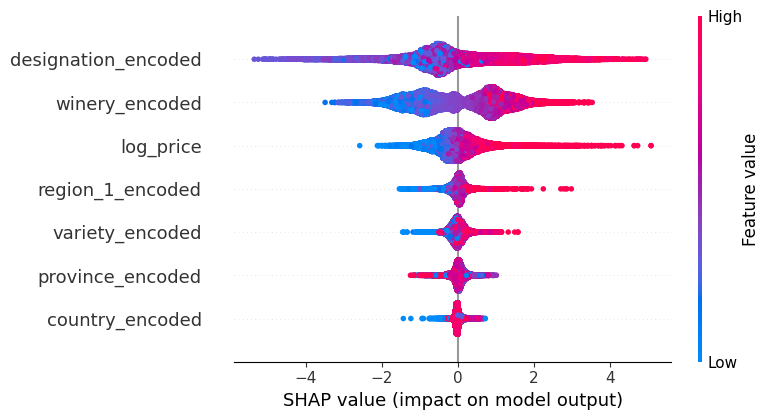

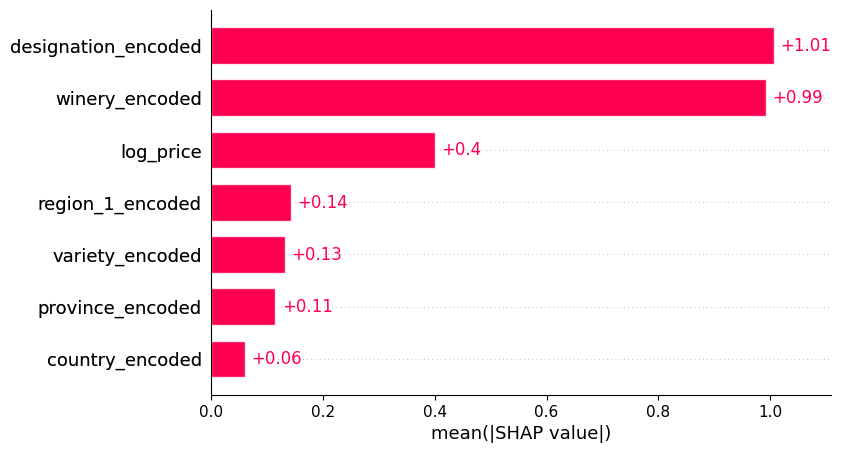

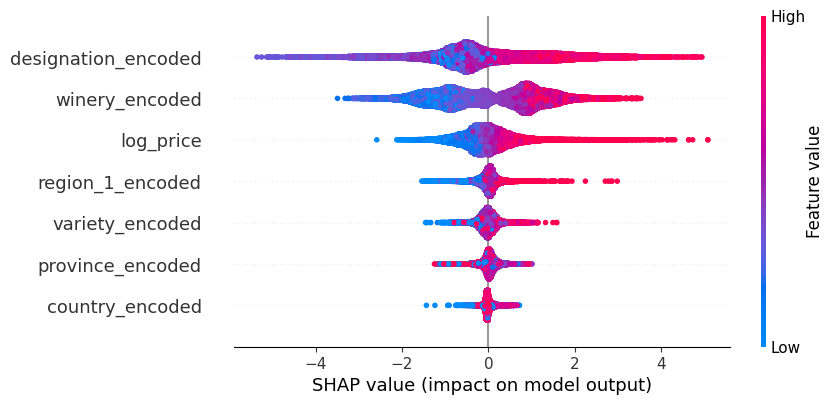

In [45]:
import shap

explainer = shap.Explainer(lgb)
shap_values = explainer(X_train)

shap.summary_plot(shap_values, X_train, feature_names = X_train.columns.tolist())
shap.plots.bar(shap_values)
shap.plots.beeswarm(shap_values)

<!-- Зеленый блок успеха -->
<div style="border: 1px solid #4CAF50; padding: 10px; background-color: #e8f5e9; border-radius: 5px;">
    <strong>Conclusion:</strong> lightGBM found to be the best model for predicting wine ratings
</div>